# Data Cleaning 

### Imports

In [1]:
#standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#preprocessing imports
from sklearn.preprocessing import LabelEncoder
import re
from nltk.corpus import stopwords
import string

from nltk import FreqDist
#setting a seed
seed = 42

### Data

The data is from [data.world](https://data.world/crowdflower/brands-and-product-emotions). The sentiment of approximately 9000 tweets were categorized by human raters as positive, negative, or neither. This data will be used to build a model that can rate the sentiment of a Tweet based on its content.

In [2]:
#read in data
df = pd.read_csv('../../data/judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')

In [3]:
#reviewing import
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.shape

(9093, 3)

In [5]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


There are 9092 tweets in the dataset, but only 9065 are unique showing there are duplicate tweets in the dataset that will need to be dropped so they are not double counted. 

In [6]:
#review of columns, data types, and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


At first observation the columns are do not have easy to interpret names. There are quite a few nulls in the `emotion_in_tweet_is_directed_at` column, 1 null in `tweet_text`, and no nulls in the `is_there_an_emotion_directed_at_a_brand_or_product` column. 

Based on this I will: 
1. Rename the columns
2. Handle duplicates
3. Handle nulls

In [7]:
#rename columns
df.columns = ['tweet', 'product', 'emotion']

#drop tweet null
df.dropna(subset=['tweet'], inplace=True)

#fill product as 'none'
df['product'].fillna(value='None', inplace=True)

#drop duplicates
df.drop_duplicates(subset=['tweet'], inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9065 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    9065 non-null   object
 1   product  9065 non-null   object
 2   emotion  9065 non-null   object
dtypes: object(3)
memory usage: 283.3+ KB


### Target Variable Exploration

This project aims to categorize the sentiment of tweets. The target variable in this case is `emotion`.

In [9]:
emotions = df['emotion'].value_counts()
print(emotions)

No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: emotion, dtype: int64


In [10]:
#making emotion lables more concise

#set label
new_emotions = ['Neutral', 'Positive', 'Negative', 'Unsure']
new_emotions_dict = dict(zip(emotions.index, new_emotions))

#replace new labes
df['emotion'] = df['emotion'].replace(new_emotions_dict)

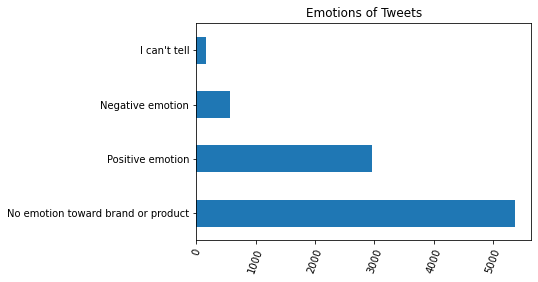

In [11]:
emotions.plot(kind='barh')
plt.title('Emotions of Tweets')
plt.xticks(rotation = 70);

There is imbalance in the target varaiable. Most of the tweets do not have an emotion. There is also an imbalance within the tweets that contain sentiment. Positive emotions occur approximately five times more than negative emotions within the dataset. There is also an `unsure` label. The `unsure` tweets do not help to establish sentiment of the tweets. I will drop them.

In [12]:
#find unsure
unsure = df.loc[df['emotion']=='Unsure'].index

#drop unsure
df.drop(unsure, inplace=True)

### Product Exploration
Exploring 'product' column which was originally the 'emotion_in_tweet_is_directed_at' column. Which products and brands are included in the dataset? 

In [13]:
products = df['product'].value_counts()

<ipython-input-14-15871cdf1f96>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(products.index, rotation=80)
<ipython-input-14-15871cdf1f96>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(products.index[1:], rotation=80);


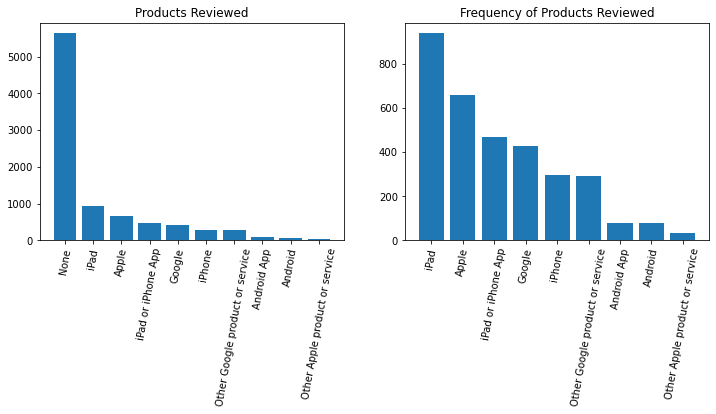

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax[0].bar(products.index, products)
ax[0].set_title('Products Reviewed')
ax[0].set_xticklabels(products.index, rotation=80)

ax[1].bar(products.index[1:], products[1:])
ax[1].set_title('Frequency of Products Reviewed')
ax[1].set_xticklabels(products.index[1:], rotation=80);

As with the target variable, there is an inbalance between the items. Of the tweets that contian a product or brand, the majority were directed towards iPad. The top three times with emotions are all related to Apple (iPad, Apple, iPad or iPhone App). The other items are related to Google. For this reason, it would be interesting to form a `brand` column for our dataframe. 

In [15]:
#create brand pairing
brand = ['NA', 'Apple', 'Apple', 'Apple', 'Google', 'Apple', 'Google', 'Google', 'Google', 'Apple']
product_list = list(products.index)

#create brand column
product_brand = dict(zip(product_list, brand))
df['brand'] = df['product'].replace(product_brand)

Apple
Positive    0.811273
Negative    0.161587
Neutral     0.027140
Name: emotion, dtype: float64

Google
Positive    0.820776
Negative    0.149543
Neutral     0.029680
Name: emotion, dtype: float64

NA
Neutral     0.936680
Positive    0.054275
Negative    0.009046
Name: emotion, dtype: float64



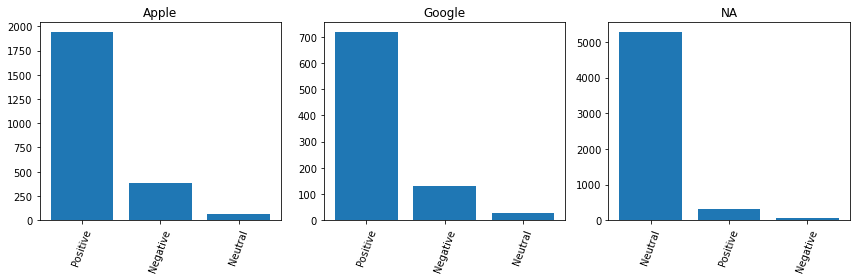

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

for n, item in enumerate(list(df['brand'].unique())):
    
    #product emotions
    item_df = df.loc[df['brand']== item]
    item_emotion = item_df['emotion'].value_counts()
    
    
    #plot graphs
    ax[n].bar(item_emotion.index, item_emotion)
    ax[n].set_title(item)
    ax[n].tick_params(axis='x', labelrotation=70)
      
    print(item)
    print(item_df['emotion'].value_counts(normalize=True))
    print()

plt.tight_layout();

When comparing by brand. Apple has more tweets associated with their products/brands than google. They both have similar ratios of positive to negative to none emotions.

### Encode categorical data as categories
The columns `emotion`, `product` and `brand` are all categorical in nature. In order to effectively processes these column types as categories in future modeling I will encode theses columns as categories. 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8909 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    8909 non-null   object
 1   product  8909 non-null   object
 2   emotion  8909 non-null   object
 3   brand    8909 non-null   object
dtypes: object(4)
memory usage: 348.0+ KB


In [18]:
def create_category(column):
    df[column] = df[column].astype('category')

In [19]:
categorical = ['emotion', 'product', 'brand']

for element in categorical: 
    create_category(element)

In [20]:
#encode target
le =LabelEncoder()
le.fit(df['emotion'].values)
df['emotion_label'] = le.transform(df['emotion'].values)

labels = list(le.classes_)
print(labels)

['Negative', 'Neutral', 'Positive']


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8909 entries, 0 to 9092
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   tweet          8909 non-null   object  
 1   product        8909 non-null   category
 2   emotion        8909 non-null   category
 3   brand          8909 non-null   category
 4   emotion_label  8909 non-null   int32   
dtypes: category(3), int32(1), object(1)
memory usage: 200.7+ KB


### Additional Features
There may be other features within the tweets to explore. I will make columns for: 
* length of tweet
* if the tweet contains exclamation marks
* if the tweet contains hashtags 
* if the tweet contains mentions
* if the tweet conaints sentiment (positive or negative)

In [22]:
#length of tweet
df['length'] = df['tweet'].apply(lambda x: len(x))

#has exclamation function
def exclamation(tweet):
    if '!' in tweet:
        return True
    else:
        return False

#create exclamation column
df['exclamation'] = df['tweet'].apply(lambda x: exclamation(x))

#hashtag
df['hashtag'] = df['tweet'].apply(lambda x: re.findall('(\#[a-zA-Z0-9_%]*)', x))

#mentions
df['mention'] = df['tweet'].apply(lambda x: re.findall("@([a-zA-Z0-9_]{1,50})", x))

#sentiment
def sentiment(emotion):
    if emotion in ['Positive', 'Negative']:
        return True
    else:
        return False

#create sentiment column
df['sentiment'] = df['emotion'].apply(lambda x: sentiment(x)).astype(bool)

In [23]:
df.head()

,tweet,product,emotion,brand,emotion_label,length,exclamation,hashtag,mention,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,0,127,True,"[#RISE_Austin, #SXSW]",[wesley83],True
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,2,139,False,[#SXSW],"[jessedee, fludapp]",True
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,2,79,False,"[#iPad, #SXSW]",[swonderlin],True
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,0,82,False,[#sxsw],[sxsw],True
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,2,131,False,[#SXSW],[sxtxstate],True


### Text Cleaning
Next I will clean the text in the `tweet` column in order to model with NLP. Consdiering that the data in this column represents tweets, they have certain charactericts that are unique to social media such as hashtags(#), mentions of a user (@), retweets (rt), and links to websites ({link}). In addition to traditional preprocessing for NLP I will need to address these elements too.

To clean the text I will: 
1. Change all words to lowercase
2. Remove {links} and websites mentioned
3. Standardize mentions so that all mentions are @mention instead of specific users
4. Remove hashtag, but keep the content of the hashtag
5. Remove punctuation 
6. Tokenize the words
7. Remove stopwords

I will create a column of clean tweets and a column of the tweets tokenized. 

In [24]:
print(df['tweet'][0])
print(df['tweet'][32])
print(df['tweet'][14])

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
Attn: All  #SXSW frineds, @mention Register for #GDGTLive  and see Cobra iRadar for Android. {link}
Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l


In [25]:
#all words to lowercase
df['clean_tweet'] = df['tweet'].apply(lambda x: x.lower())

#remove links
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub('{link}',' ', x))
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'http\S+', ' ', x))

#standarize mentions
def mention(tweet):
    mentions = re.findall("@([a-zA-Z0-9_]{1,50})", tweet)
    for user in mentions:
        tweet = tweet.replace(user, 'mention')
    return tweet
        
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: mention(x))

#remove hashtag
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub('#',' ', x))

#remove punctuation and non-characters
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'[^\x1F-\x7F]+', ' ', x))

def remove_characters(tweet, characters):
    new_tweet = [x for x in tweet if x not in characters]
    return "".join(new_tweet)

df['clean_tweet'] = df['clean_tweet'].apply(lambda x: remove_characters(x, string.punctuation))

#remove punctuation and non-characters
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub('[0-9\n]',' ',x))

#strip whitespace
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub('[ ]{2,}',' ',x))

In [26]:
print('Before cleaning:')
print(df['tweet'][0])
print(df['tweet'][32])
print(df['tweet'][14])
print()
print('After cleaning:')
print(df['clean_tweet'][0])
print(df['clean_tweet'][32])
print(df['clean_tweet'][14])

Before cleaning:
.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
Attn: All  #SXSW frineds, @mention Register for #GDGTLive  and see Cobra iRadar for Android. {link}
Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l

After cleaning:
mention i have a g iphone after hrs tweeting at riseaustin it was dead i need to upgrade plugin stations at sxsw
attn all sxsw frineds mention register for gdgtlive and see cobra iradar for android 
great sxsw ipad app from mention 


**Tokenization** is splitting a phrase, in this case each tweet, into the individual words that are contained within the tweet. The resulting individual words are tokens.

In [27]:
df['tokens'] = df['clean_tweet'].apply(lambda x: x.split())

**Stop words** are words that are used so commonly in the english language. They are removed because they do not add meaninful information to the data set. Since tweets are short, removing all of the stopwords provided by NLTK's english stopwords list may be too many. Therefore, I will review the overall composition of the tokens before choosing which stopwords are appropriate to remove. 

The current state of the data:

In [28]:
df.head()

,tweet,product,emotion,brand,emotion_label,length,exclamation,hashtag,mention,sentiment,clean_tweet,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,0,127,True,"[#RISE_Austin, #SXSW]",[wesley83],True,mention i have a g iphone after hrs tweeting a...,"[mention, i, have, a, g, iphone, after, hrs, t..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,2,139,False,[#SXSW],"[jessedee, fludapp]",True,mention know about mention awesome ipadiphone ...,"[mention, know, about, mention, awesome, ipadi..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,2,79,False,"[#iPad, #SXSW]",[swonderlin],True,mention can not wait for ipad also they should...,"[mention, can, not, wait, for, ipad, also, the..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,0,82,False,[#sxsw],[sxsw],True,mention i hope this years festival isnt as cra...,"[mention, i, hope, this, years, festival, isnt..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,2,131,False,[#SXSW],[sxtxstate],True,mention great stuff on fri sxsw marissa mayer ...,"[mention, great, stuff, on, fri, sxsw, marissa..."


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8909 entries, 0 to 9092
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   tweet          8909 non-null   object  
 1   product        8909 non-null   category
 2   emotion        8909 non-null   category
 3   brand          8909 non-null   category
 4   emotion_label  8909 non-null   int32   
 5   length         8909 non-null   int64   
 6   exclamation    8909 non-null   bool    
 7   hashtag        8909 non-null   object  
 8   mention        8909 non-null   object  
 9   sentiment      8909 non-null   bool    
 10  clean_tweet    8909 non-null   object  
 11  tokens         8909 non-null   object  
dtypes: bool(2), category(3), int32(1), int64(1), object(5)
memory usage: 886.1+ KB


## Exploratory Data Analysis 
Now that the data is cleaner I can explore in more depth to find trends to create and modify features based on insights gained during EDA.

I previously explored the target variable `emotion` along with the `products` and `brands` found in the data. 

**Products by emotion** Previous trends showed that tweets containing a brand or product contained sentiment. I will explore how the sentiment breaks down by product and brand.

In [30]:
products=list(df['product'].unique())

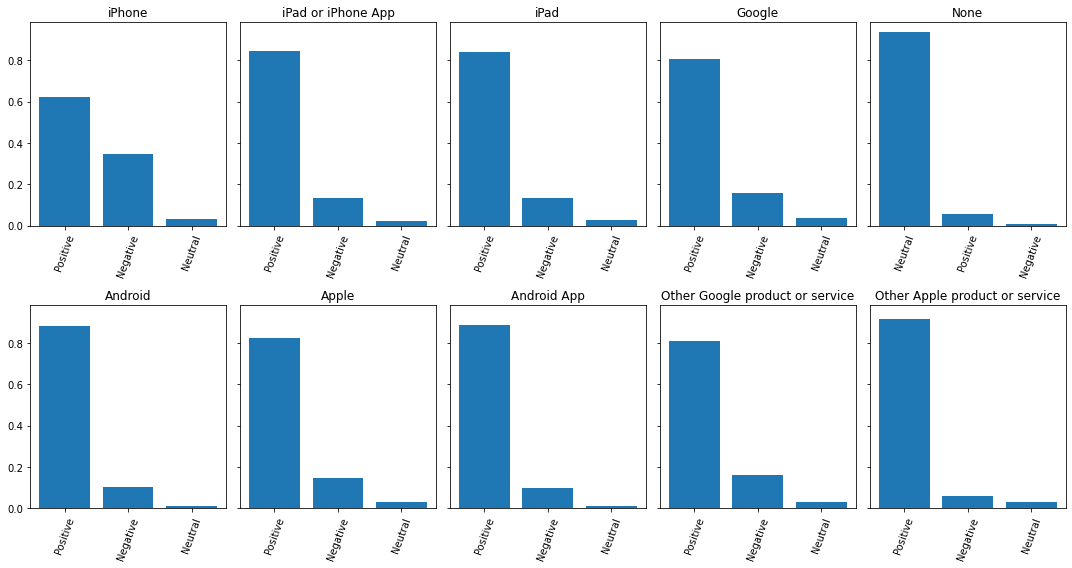

In [31]:
products=list(df['product'].unique())

fig, ax = plt.subplots(ncols=(len(products)//2), nrows=2, sharey=True, figsize=(15,8))

for c, item in enumerate(products):
    
    #establish column and row numbers
    if c<(len(products)//2): 
        n = 0
    else: 
        n = 1
    
    if n == 1:
        c = c - 5
    
    #item product ratings
    item_df = df.loc[df['product']== item]
    item_emotion = item_df['emotion'].value_counts(normalize=True)
    
    
    #plot graphs
    ax[n,c].bar(item_emotion.index, item_emotion)
    ax[n,c].set_title(item)
    ax[n,c].tick_params(axis='x', labelrotation=70)

plt.tight_layout();

If an emotion was directed towards a brand or product most of the time it was a positive emotion. When tweets were *not* directed towards a product or a brand, then the tweets were also *not* associated with a particular emotion. 

The ratio of positive to negative senitment amongst the products is generally proportional to the overall ratio of positive to negative sentiment within the entire dataset. The exception to this is iPhone which have more negative sentiment relative to the dataset overall.

**Tweet length by emotion** I created a new column that contained the lengths of tweets. I will explore the variability among tweet lenghts and if length has a relationship with a particular emotion or sentiment in general.

In [32]:
df['length'].describe()

count    8909.000000
mean      104.986643
std        27.179668
min        11.000000
25%        86.000000
50%       109.000000
75%       126.000000
max       178.000000
Name: length, dtype: float64

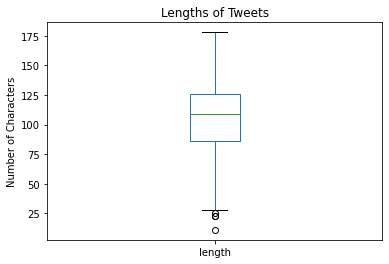

In [33]:
df['length'].plot(kind='box')
plt.title('Lengths of Tweets')
plt.ylabel('Number of Characters');

Short Tweets Count
Neutral     1401
Positive     752
Negative     124
Name: emotion, dtype: int64

Long Tweets Count
Neutral     1286
Positive     808
Negative     200
Name: emotion, dtype: int64


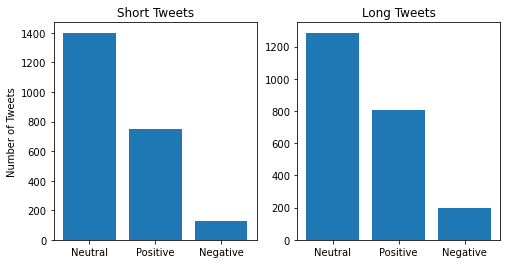

In [34]:
#finding the bottom 25% of tweets by length and top 25% of tweets by length.
short_tweets = df.loc[df['length']<=df['length'].quantile(0.25)]['emotion'].value_counts()
long_tweets = df.loc[df['length']>=df['length'].quantile(0.75, interpolation='higher')]['emotion'].value_counts()

#Frequency of emotional sentiment by tweet length
print('Short Tweets Count')
print(short_tweets)
print()
print('Long Tweets Count')
print(long_tweets)


fig, ax = plt.subplots(ncols=2, figsize=(8,4))

ax[0].bar(short_tweets.index, short_tweets)
ax[0].set_title("Short Tweets")
ax[0].set_ylabel("Number of Tweets")

ax[1].bar(long_tweets.index, long_tweets)
ax[1].set_title("Long Tweets");

Tweets in this dataset range from 11 to 178 characters. The sentiment is similar between the shortest tweets in the set (bottom 25%) and the longest tweets in the dataset (top 25%).

In [35]:
#correlation between length and lable
df['length'].corr(df['emotion_label'])

-0.005183473066303838

**Exclamation Marks** Do exclamation marks have an impact on sentiment? During cleaning we removed them from the dataset, but would keeping them in help to predict sentiment? 

In [36]:
df_exclaim = df.loc[(df['exclamation']==True)]

exc_and_sent = len(df.loc[(df['exclamation']==True) & (df['sentiment']==True)])
exc_and_nosent = len(df.loc[(df['exclamation']==True) & (df['sentiment']==False)])

noexc_and_sent = len(df.loc[(df['exclamation']==False) & (df['sentiment']==True)])
noexc_and_nosent = len(df.loc[(df['exclamation']==False) & (df['sentiment']==False)])

print(exc_and_sent, exc_and_nosent, noexc_and_sent, noexc_and_nosent)

937 827 2600 4545


### Words
After reviwing overall trends related to the target emotions. I will explore the content of the tweets through the token words within the data. While processing the text, I noted that removing all of the stopwords may be too heavy-handed for this dataset since it is composed of short tweets. The purpose of this exploration is to determine the best tokens for the data set.

In [37]:
#function for visualizing the most frequent tokens within a frequency distribution
def visualize_tokens(freq_dist, number, title):
    '''
    freq_dist: pass in frequency dictionary of tokens
    
    number: number as integer of the top tokens to return
    
    title: title of graph
    '''
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator

    # get tokens and frequency counts from freq_dist
    top = list(zip(*freq_dist.most_common(number)))
    tokens = top[0]
    counts = top[1]
    
    print(f'Top Tokens: {tokens[:number]}')

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

Top Tokens: ('sxsw', 'mention', 'the', 'to', 'at', 'rt', 'ipad', 'for', 'google', 'a', 'apple', 'in', 'of', 'is', 'and', 'iphone', 'store', 'on', 'new', 'i')


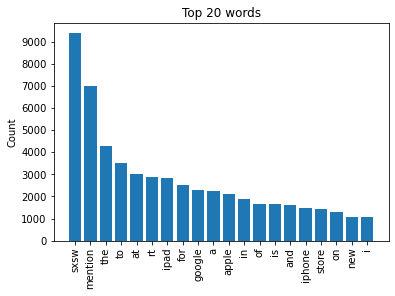

In [38]:
#getting all tokens 
all_tokens = df['tokens'].explode()

freq_dist_all = FreqDist(all_tokens)

visualize_tokens(freq_dist_all, 20, "Top 20 words")

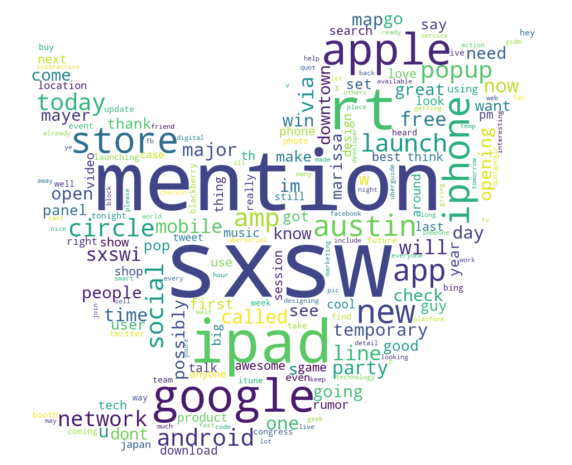

In [39]:
from wordcloud import WordCloud
from PIL import Image
from os import path
masktwit = np.array(Image.open('twittermask.png'))

wordcloud = WordCloud(collocations=False, 
                      background_color="white", 
                      mask=masktwit).generate(" ".join(all_tokens))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

In [40]:
print(freq_dist_all.most_common(50))

[('sxsw', 9396), ('mention', 7023), ('the', 4291), ('to', 3528), ('at', 3016), ('rt', 2882), ('ipad', 2849), ('for', 2503), ('google', 2284), ('a', 2237), ('apple', 2116), ('in', 1899), ('of', 1678), ('is', 1666), ('and', 1604), ('iphone', 1488), ('store', 1444), ('on', 1300), ('new', 1073), ('i', 1049), ('austin', 935), ('you', 924), ('with', 853), ('an', 852), ('up', 811), ('app', 807), ('my', 802), ('it', 761), ('amp', 713), ('launch', 636), ('social', 622), ('circles', 605), ('this', 598), ('popup', 591), ('android', 559), ('today', 550), ('be', 546), ('just', 545), ('from', 527), ('not', 509), ('by', 507), ('out', 502), ('are', 501), ('your', 465), ('that', 458), ('network', 450), ('via', 424), ('have', 419), ('will', 397), ('line', 395)]


In [41]:
#visual inspection of location tweets
tx_df = df.loc[df['clean_tweet'].str.contains('tx')]
tx_df.head()

,tweet,product,emotion,brand,emotion_label,length,exclamation,hashtag,mention,sentiment,clean_tweet,tokens
133,"#Samsung, #Sony follow #Apple, #HP lead @menti...",None,Neutral,NA,1,74,False,"[#Samsung, #Sony, #Apple, #HP, #Austin, #atx, ...",[mention],False,samsung sony follow apple hp lead mention aus...,"[samsung, sony, follow, apple, hp, lead, menti..."
134,"#Samsung, #Sony follow #Apple, #HP lead @menti...",None,Neutral,NA,1,92,False,"[#Samsung, #Sony, #Apple, #HP, #Austin, #atx, ...","[mention, mention]",False,samsung sony follow apple hp lead mention aus...,"[samsung, sony, follow, apple, hp, lead, menti..."
287,"At #SXSW, Apple schools the marketing experts ...",Apple,Positive,Apple,2,86,False,"[#SXSW, #Austin, #ATX, #retail]",[],True,at sxsw apple schools the marketing experts cn...,"[at, sxsw, apple, schools, the, marketing, exp..."
348,"March 11. Austin, TX. Will people line up at t...",None,Neutral,NA,1,94,False,[#SXSW],[],False,march austin tx will people line up at the sxs...,"[march, austin, tx, will, people, line, up, at..."
417,Shipments daily - follow @mention #AppleATXdt ...,None,Negative,NA,0,126,False,"[#AppleATXdt, #SXSW]","[mention, mention]",True,shipments daily follow mention appleatxdt upda...,"[shipments, daily, follow, mention, appleatxdt..."


Most of the tweets contain the word "sxsw" and "mention." Mention was introduced into the tweets by us, to note if the person was directly tweeting to another person. "@" and usernames were replaced with "mention." Another top word is "rt" to represent a retweet. Products and brands are also included prominately in the tokens. Since the aim of this project is to produce a model for social media manager of a technology company to monitor the sentiment of tweets, it makes sense to keep technology-based words within the tokens and remove the location-specific tokens so the model is generalizable to other regions. Additionally, often considered stopwords such as "and" do not appear among the most frequent words. 

Given the context above I will: 
1. Remove the three most common tokens ('sxsw', 'mention', 'rt')
2. Remove location-based tokens ('texas', 'tx', 'sxswtx', 'austin', 'atx')

In [42]:
#remove words from tokens
words_to_remove = ['sxsw', 'mention', 'rt', 'tx', 'austin', 'sxswtx', 'texas', 'the', 'to', 'at','a','and','on', 'in', 'of', 'is']

df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in words_to_remove])

Top Tokens: ('ipad', 'for', 'google', 'apple', 'iphone', 'store', 'new', 'i', 'you', 'with', 'an', 'up', 'app', 'my', 'it')


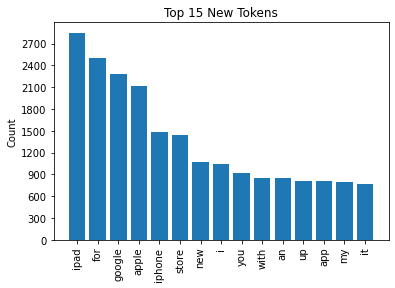

In [43]:
new_tokens = df['tokens'].explode()

new_freq_dist = FreqDist(new_tokens)

visualize_tokens(new_freq_dist, 15, 'Top 15 New Tokens')

In [44]:
new_tokens = [str(x) for x in new_tokens.values]

In [45]:
from PIL import Image
from os import path
masktwit = np.array(Image.open('twittermask.png'))

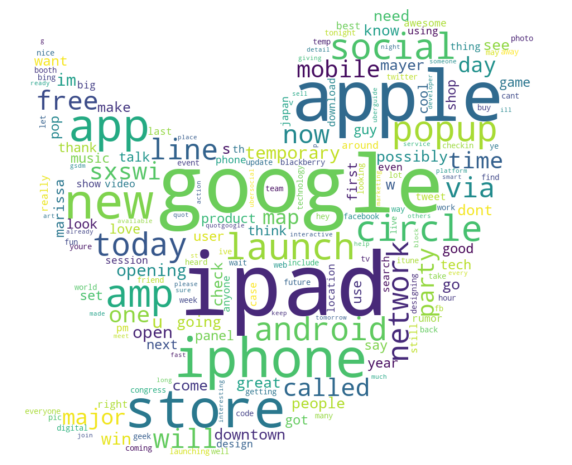

In [46]:
wordcloud = WordCloud(collocations=False, 
                      background_color="white", 
                      mask=masktwit).generate(" ".join(new_tokens))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

In [47]:
df.head()

,tweet,product,emotion,brand,emotion_label,length,exclamation,hashtag,mention,sentiment,clean_tweet,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,0,127,True,"[#RISE_Austin, #SXSW]",[wesley83],True,mention i have a g iphone after hrs tweeting a...,"[i, have, g, iphone, after, hrs, tweeting, ris..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,2,139,False,[#SXSW],"[jessedee, fludapp]",True,mention know about mention awesome ipadiphone ...,"[know, about, awesome, ipadiphone, app, that, ..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,2,79,False,"[#iPad, #SXSW]",[swonderlin],True,mention can not wait for ipad also they should...,"[can, not, wait, for, ipad, also, they, should..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,0,82,False,[#sxsw],[sxsw],True,mention i hope this years festival isnt as cra...,"[i, hope, this, years, festival, isnt, as, cra..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,2,131,False,[#SXSW],[sxtxstate],True,mention great stuff on fri sxsw marissa mayer ...,"[great, stuff, fri, marissa, mayer, google, ti..."


In [63]:
df['emotion_label'].value_counts()

1    5372
2    2968
0     569
Name: emotion_label, dtype: int64

In [61]:
#keeping only the relevant columns for modeling 
final_df = df[['emotion_label', 'tokens']]
final_df.head()

,emotion_label,tokens
0,0,"[i, have, g, iphone, after, hrs, tweeting, ris..."
1,2,"[know, about, awesome, ipadiphone, app, that, ..."
2,2,"[can, not, wait, for, ipad, also, they, should..."
3,0,"[i, hope, this, years, festival, isnt, as, cra..."
4,2,"[great, stuff, fri, marissa, mayer, google, ti..."


In [62]:
final_df['emotion_label'].value_counts()

1    5372
2    2968
0     569
Name: emotion_label, dtype: int64

In [64]:
def change_label(x):
    if x==0:
        x = 1
    return x        
        
final_df['emotion_label'] = final_df['emotion_label'].apply(lambda x: change_label(x))
final_df.head()

<ipython-input-64-49d1a1691092>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['emotion_label'] = final_df['emotion_label'].apply(lambda x: change_label(x))


,emotion_label,tokens
0,1,"[i, have, g, iphone, after, hrs, tweeting, ris..."
1,2,"[know, about, awesome, ipadiphone, app, that, ..."
2,2,"[can, not, wait, for, ipad, also, they, should..."
3,1,"[i, hope, this, years, festival, isnt, as, cra..."
4,2,"[great, stuff, fri, marissa, mayer, google, ti..."


In [65]:
final_df['emotion_label'].value_counts()

1    5941
2    2968
Name: emotion_label, dtype: int64

## Train Test Split

In [66]:
from sklearn.model_selection import train_test_split

X= final_df['tokens'].apply(lambda x: " ".join(x))
y= final_df['emotion_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size= 0.3, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size=0.3, stratify=y_test)

In [67]:
X_train

564     attending google keynote seeing google maps fo...
861     love it quotapple comes up w cool technology n...
5772    get it while its hot latest version whrrl avai...
3731    team heading big boi show thanks crew find owl...
8551    congrats kenny who now enjoys spanking new cas...
                              ...                        
3309      ipad design headaches with josh clark tapworthy
3022    more farmers use blackberry than iphone but ip...
3404                             haha for which iphone or
7813    battery life my iphone conference only just st...
5652    dancing with myself google s party aint that t...
Name: tokens, Length: 6236, dtype: object

## Modeling

In [68]:
y_train.value_counts(normalize=True)

1    0.666774
2    0.333226
Name: emotion_label, dtype: float64

In [69]:
# imports for modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score, recall_score, f1_score

In [70]:
model_results = pd.DataFrame(columns=['model', 'crosval', 'accuracy', 'precision', 'recall'])

In [71]:
def model_evaluation(model, X_tr, y_tr, X_te, y_te):
    '''
    Evaluates model using cross_val_score and accuracy_score
    Returns scores and confusion matrix
    
    Inputs: 
    model: fitted to X_tr
    X_tr: traning variable
    y_tr: training target
    X_te: test variable
    y_te: test target
    '''

    print('Average Cross Validation Score:')
    print(cross_val_score(model, X_tr, y_tr).mean())
    print()
    print('Test Accuracy:')
    print(accuracy_score(y_te, model.predict(X_te)))
    print()
    print('Precision Score:')
    print(precision_score(y_te, model.predict(X_te)))
    print()
    print('Recall Score:')
    print(recall_score(y_te, model.predict(X_te)))
    print('F1 Score:')
    print(f1_score(y_te, model.predict(X_te)))
    
    plot_confusion_matrix(model, X_te, y_te);

Tokens in Vectorizer:8575

Average Cross Validation Score:
0.6991674891534554

Test Accuracy:
0.7033671833244255

Precision Score:
0.6974358974358974

Recall Score:
0.9807692307692307
F1 Score:
0.8151848151848152


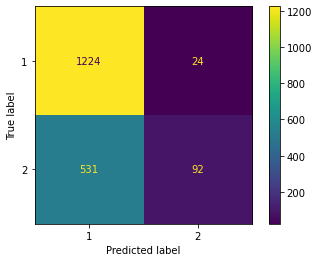

In [73]:
#instantiate vectorizer
tfidf = TfidfVectorizer()

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

print(f'Tokens in Vectorizer:{X_train_vectorized.shape[1]}\n')

#instantiate model and fit
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(nb_model, X_train_vectorized, y_train, X_test_vectorized, y_test)

For a first model, without any tuning, this predicts the sentiment of a tweet with 69% accuracy. Since I did not remove a significant number of stop words when cleaning the data, I will explore limiting the features in the Vectorizer to see the impace on the MultinomialNB Model.

Tokens in Vectorizer:2233

Average Cross Validation Score:
0.7127985370016244

Test Accuracy:
0.7113842864778194

Precision Score:
0.7150668286755771

Recall Score:
0.9431089743589743
F1 Score:
0.8134070490670352


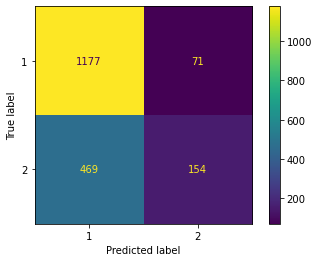

In [74]:
#instantiate vectorizer
tfidf = TfidfVectorizer(min_df=4)

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

print(f'Tokens in Vectorizer:{X_train_vectorized.shape[1]}\n')

#instantiate model and fit
nb_model2 = MultinomialNB()
nb_model2.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(nb_model2, X_train_vectorized, y_train, X_test_vectorized, y_test)

Reducing the dimensions of the vectorizer improved the model by approximately 4%. Next, I will explore reducing the dimensions of the vectorized tokens by limiting the number of features to 1000. For reference, the first model contained approximately 8000 features, followed by 2000 features in the second model.

Tokens in Vectorizer:1000

Average Cross Validation Score:
0.7152050819402463

Test Accuracy:
0.7156600748262961

Precision Score:
0.7182926829268292

Recall Score:
0.9439102564102564
F1 Score:
0.8157894736842105


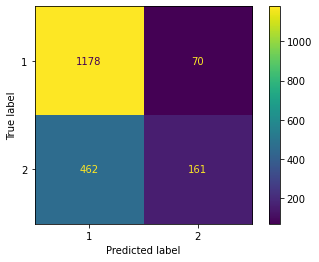

In [75]:
#instantiate vectorizer
tfidf = TfidfVectorizer(max_features=1000) #limited features

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

print(f'Tokens in Vectorizer:{X_train_vectorized.shape[1]}\n')

#instantiate model and fit
nb_model3 = MultinomialNB()
nb_model3.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(nb_model3, X_train_vectorized, y_train, X_test_vectorized, y_test)

Reducing the number of features in the vectorizer did not improve the model. In the next model, I will adjust the `fit_prior` parameter to the MultinomialNB model and return the parameters for the vectorizer to the better state. 

Average Cross Validation Score:
0.6648487138362841

Test Accuracy:
0.6830571886691609

Precision Score:
0.8040854224698236

Recall Score:
0.6939102564102564
F1 Score:
0.7449462365591397


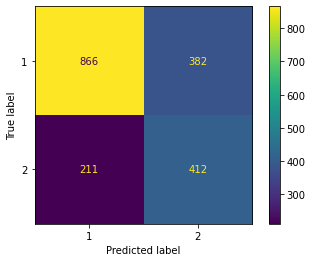

In [76]:
#instantiate vectorizer
tfidf = TfidfVectorizer(min_df=4) #returned min_df 4

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

#instantiate model and fit
nb_model4 = MultinomialNB(fit_prior=False)
nb_model4.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(nb_model4, X_train_vectorized, y_train, X_test_vectorized, y_test)

While this model performed less accurately than the previous model, it shows an interesting change in the predictions of the model overall. This model produces fewer false negatives and more false positives. Turning off the `fit_prior` parameter adjusted the model's calulation of the distribution of the target variable. Therefore, in future models it would be benificial to choose a modle that accounts for the imbalance in this data's target variable.

ComplementNB ["is particularly suited for imbalanced data sets"](https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes) according to scikit-learn. 

In [77]:
from sklearn.naive_bayes import ComplementNB

Average Cross Validation Score:
0.6860160539140091

Test Accuracy:
0.7194013896312133

Precision Score:
0.763292061179898

Recall Score:
0.8397435897435898
F1 Score:
0.7996947729874093


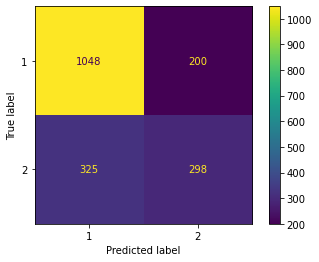

In [78]:
#instantiate vectorizer
tfidf = TfidfVectorizer() 

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

#instantiate model and fit
nb_model5 = ComplementNB()
nb_model5.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(nb_model5, X_train_vectorized, y_train, X_test_vectorized, y_test)

Wihtout parameters this model is as accurate overall as a previous model. It is producing a higher number of false negatives. Next, I will apply tuning parameters

Average Cross Validation Score:
0.5577309902740938

Test Accuracy:
0.6536611437733832

Precision Score:
0.6976284584980237

Recall Score:
0.8485576923076923
F1 Score:
0.7657266811279827


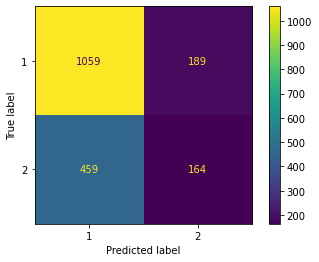

In [79]:
#instantiate vectorizer
tfidf = TfidfVectorizer(max_df=2) #reduce dimensionality

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

#instantiate model and fit
nb_model6 = ComplementNB()
nb_model6.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(nb_model6, X_train_vectorized, y_train, X_test_vectorized, y_test)

Reducing dimensionality did not improve the model. The results show the model's attempt to correct for an imbalanced dataset and predicted no sentiment significantly more than positive sentiment. However we were able to achieve more accurate results with other models.

In [80]:
from sklearn.linear_model import LogisticRegression

Average Cross Validation Score:
0.7251462484321346

Test Accuracy:
0.7349011223944415

Precision Score:
0.7361809045226131

Recall Score:
0.9391025641025641
F1 Score:
0.8253521126760563


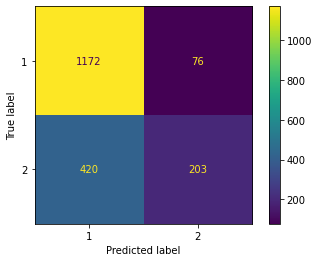

In [81]:
#instantiate vectorizer
tfidf = TfidfVectorizer() 

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

#instantiate model and fit
le_model7 = LogisticRegression()
le_model7.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(le_model7, X_train_vectorized, y_train, X_test_vectorized, y_test)

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Average Cross Validation Score:


C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

0.7001262003166574

Test Accuracy:
0.6958845537145911

Precision Score:
0.7650273224043715

Recall Score:
0.7852564102564102
F1 Score:
0.77500988533017


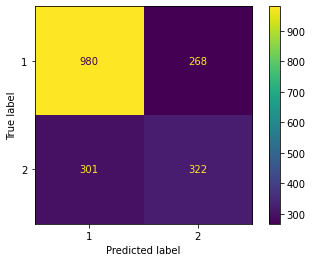

In [82]:
#instantiate vectorizer
tfidf = TfidfVectorizer() #reduce dimensionality

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

#instantiate model and fit
le_model8 = LogisticRegression(penalty='none')
le_model8.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(le_model8, X_train_vectorized, y_train, X_test_vectorized, y_test)

In [83]:
le_model8.n_iter_

array([100])

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Average Cross Validation Score:


C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear

0.7289939444410175

Test Accuracy:
0.743452699091395

Precision Score:
0.770042194092827

Recall Score:
0.8774038461538461
F1 Score:
0.8202247191011237


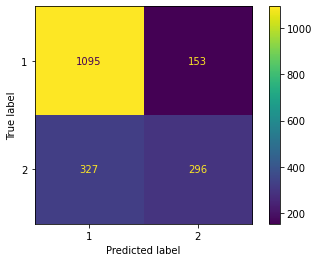

In [84]:
from sklearn.feature_extraction.text import CountVectorizer
#instantiate vectorizer
ct_vect = CountVectorizer() 

#train and transform
X_train_vectorized = ct_vect.fit_transform(X_train)
X_test_vectorized = ct_vect.transform(X_test)

#instantiate model and fit
le_model8_ct = LogisticRegression(solver='saga')
le_model8_ct.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(le_model8_ct, X_train_vectorized, y_train, X_test_vectorized, y_test)

In [85]:
le_model8_ct.n_iter_

array([100])

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Average Cross Validation Score:


C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

0.6757550171694117

Test Accuracy:
0.6686264029930519

Precision Score:
0.7544570502431118

Recall Score:
0.7459935897435898
F1 Score:
0.7502014504431909


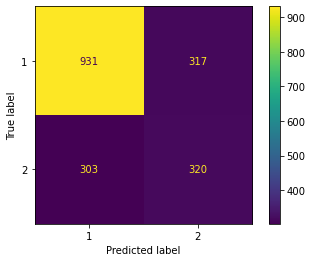

In [86]:
from sklearn.decomposition import TruncatedSVD

#instantiate vectorizer
ct_vect = CountVectorizer() 

#train and transform
X_train_vectorized = ct_vect.fit_transform(X_train)
X_test_vectorized = ct_vect.transform(X_test)

#reuce dimensionality of countvectorizer
svd = TruncatedSVD(n_components=4000, n_iter=10)
svd.fit(X_train_vectorized)
X_train_vectorized_SVD = svd.transform(X_train_vectorized)
X_test_vectorized_SVD = svd.transform(X_test_vectorized)

#instantiate model and fit
le_model8_ct = LogisticRegression(penalty='none', max_iter=1500)
le_model8_ct.fit(X_train_vectorized_SVD, y_train)

#evaluate model
model_evaluation(le_model8_ct, X_train_vectorized_SVD, y_train, X_test_vectorized_SVD, y_test)

While this failed to converge, the accuracy score was higher than some previous models and the precision score would be higher than other models.

Average Cross Validation Score:
0.676076943639093

Test Accuracy:
0.6638161411010155

Precision Score:
0.7568464730290456

Recall Score:
0.7307692307692307
F1 Score:
0.7435792906644924


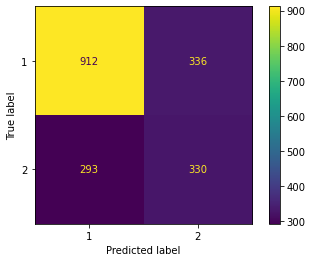

In [87]:
#instantiate vectorizer
tfidf = TfidfVectorizer() #reduce dimensionality

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

#instantiate model and fit
le_model9 = LogisticRegression(penalty='none', max_iter=10000) #increasing iterations
le_model9.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(le_model9, X_train_vectorized, y_train, X_test_vectorized, y_test)

In [88]:
le_model9.n_iter_

array([3658])

Average Cross Validation Score:


C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6735114274258219

Test Accuracy:
0.6595403527525387

Precision Score:
0.7506152584085316

Recall Score:
0.7331730769230769
F1 Score:
0.7417916497770572


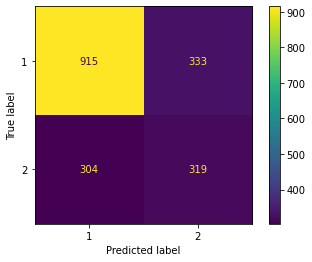

In [89]:
#instantiate vectorizer
tfidf = TfidfVectorizer(binary=True) #reduce dimensionality

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

#instantiate model and fit
le_model10 = LogisticRegression(max_iter=4500, penalty='none') 
le_model10.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(le_model10, X_train_vectorized, y_train, X_test_vectorized, y_test)

In [90]:
le_model10.n_iter_

array([2429])

Average Cross Validation Score:
0.7251462484321346

Test Accuracy:
0.7349011223944415

Precision Score:
0.7361809045226131

Recall Score:
0.9391025641025641
F1 Score:
0.8253521126760563


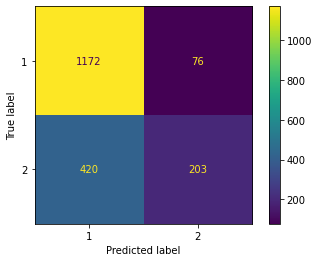

In [91]:
#instantiate vectorizer
tfidf = TfidfVectorizer() 

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

#instantiate model and fit
le_model11 = LogisticRegression() 
le_model11.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(le_model11, X_train_vectorized, y_train, X_test_vectorized, y_test)

In [92]:
le_model11.n_iter_

array([63])

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

Average Cross Validation Score:
0.6890632389529744

Test Accuracy:
0.6841261357562801

Precision Score:
0.7509549274255156

Recall Score:
0.7876602564102564
F1 Score:
0.7688697692608526


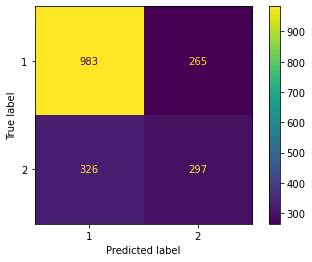

In [94]:
#instantiate vectorizer
tfidf = TfidfVectorizer() 

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

#instantiate classifier
tree_model = DecisionTreeClassifier()

#fit model
tree_model.fit(X_train_vectorized, y_train)

model_evaluation(tree_model, X_train_vectorized, y_train, X_test_vectorized, y_test)

Average Cross Validation Score:
0.682488870725639

Test Accuracy:
0.6985569214323891

Precision Score:
0.7567567567567568

Recall Score:
0.8076923076923077
F1 Score:
0.7813953488372093


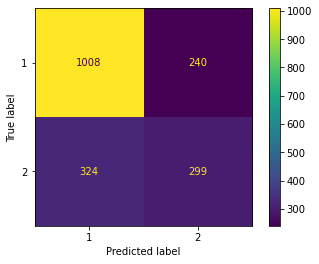

In [95]:
#instantiate vectorizer
tfidf = TfidfVectorizer(min_df=2) 

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

#instantiate classifier
tree_model = DecisionTreeClassifier()

#fit model
tree_model.fit(X_train_vectorized, y_train)

model_evaluation(tree_model, X_train_vectorized, y_train, X_test_vectorized, y_test)

Average Cross Validation Score:
0.6701433440256616

Test Accuracy:
0.6729021913415286

Precision Score:
0.7593800978792822

Recall Score:
0.7459935897435898
F1 Score:
0.7526273241713823


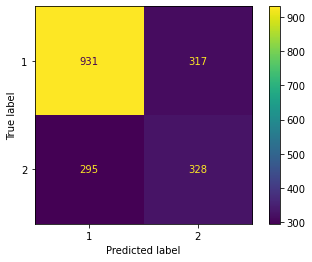

In [96]:
#instantiate vectorizer
tfidf = TfidfVectorizer(min_df=2) 

#train and transform
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

#instantiate classifier
weightdict = {1: .4, 2: .6} #account for imbalance
tree_model = DecisionTreeClassifier(class_weight=weightdict)

#fit model
tree_model.fit(X_train_vectorized, y_train)

model_evaluation(tree_model, X_train_vectorized, y_train, X_test_vectorized, y_test)

Average Cross Validation Score:
0.6962804320111857

Test Accuracy:
0.6814537680384821

Precision Score:
0.7570977917981072

Recall Score:
0.7692307692307693
F1 Score:
0.7631160572337041


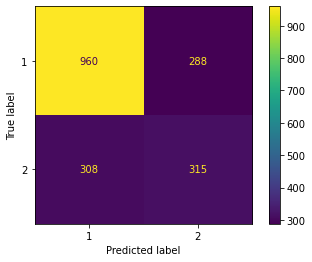

In [97]:
#instantiate vectorizer
ct_vect = CountVectorizer()

#train and transform
X_train_vectorized = ct_vect.fit_transform(X_train)
X_test_vectorized = ct_vect.transform(X_test)

#instantiate classifier
weightdict = {1: .4, 2: .6} #account for imbalance
tree_model = DecisionTreeClassifier(class_weight=weightdict)

#fit model
tree_model.fit(X_train_vectorized, y_train)

model_evaluation(tree_model, X_train_vectorized, y_train, X_test_vectorized, y_test)

## Final Model Tuning

Average Cross Validation Score:
0.7209764974400098

Test Accuracy:
0.7445216461785141

Precision Score:
0.7633378932968536

Recall Score:
0.8942307692307693
F1 Score:
0.8236162361623616


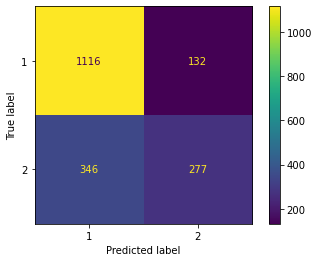

In [98]:
#instantiate vectorizer
ct_vect = CountVectorizer() 

#train and transform
X_train_vectorized = ct_vect.fit_transform(X_train)
X_test_vectorized = ct_vect.transform(X_test)

#instantiate model and fit
le_model = LogisticRegression(max_iter=3000, solver='saga', penalty='elasticnet', l1_ratio=0.5)
le_model.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(le_model, X_train_vectorized, y_train, X_test_vectorized, y_test)

In [99]:
le_model.n_iter_

array([318])

Average Cross Validation Score:
0.7305976651656283

Test Accuracy:
0.7391769107429182

Precision Score:
0.7567567567567568

Recall Score:
0.8974358974358975
F1 Score:
0.8211143695014663


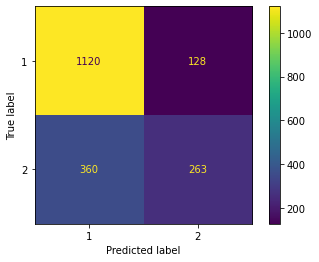

In [100]:
#instantiate vectorizer
ct_vect = CountVectorizer() 

#train and transform
X_train_vectorized = ct_vect.fit_transform(X_train)
X_test_vectorized = ct_vect.transform(X_test)

#instantiate model and fit
le_model = LogisticRegression(max_iter=700, solver='saga', C=0.5)
le_model.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(le_model, X_train_vectorized, y_train, X_test_vectorized, y_test)

Average Cross Validation Score:
0.7395769076552957

Test Accuracy:
0.7413148049171566

Precision Score:
0.7605729877216917

Recall Score:
0.8934294871794872
F1 Score:
0.8216654384672071


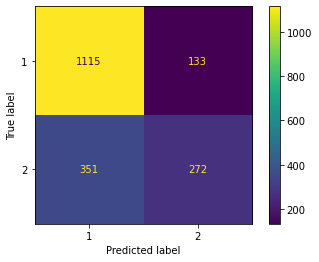

In [101]:
#instantiate vectorizer
ct_vect = CountVectorizer(stop_words='english', ngram_range=(1,2)) 

#train and transform
X_train_vectorized = ct_vect.fit_transform(X_train)
X_test_vectorized = ct_vect.transform(X_test)

#instantiate model and fit
le_model = LogisticRegression(max_iter=700, solver='saga', C=0.5)
le_model.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(le_model, X_train_vectorized, y_train, X_test_vectorized, y_test)

Average Cross Validation Score:
0.7411807568934673

Test Accuracy:
0.7514698022447889

Precision Score:
0.768334475668266

Recall Score:
0.8982371794871795
F1 Score:
0.8282231252308829


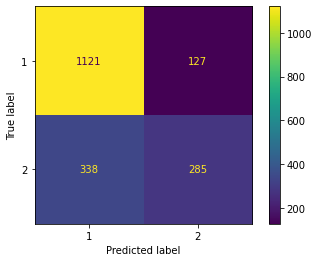

In [102]:
#instantiate vectorizer
ct_vect = CountVectorizer(ngram_range=(1,2), min_df=2) 

#train and transform
X_train_vectorized = ct_vect.fit_transform(X_train)
X_test_vectorized = ct_vect.transform(X_test)

#instantiate model and fit
le_model = LogisticRegression(max_iter=700, solver='saga', C=0.5)
le_model.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(le_model, X_train_vectorized, y_train, X_test_vectorized, y_test)

Average Cross Validation Score:
0.7426231930993358

Test Accuracy:
0.7423837520042758

Precision Score:
0.7648686030428768

Recall Score:
0.8862179487179487
F1 Score:
0.8210838901262063


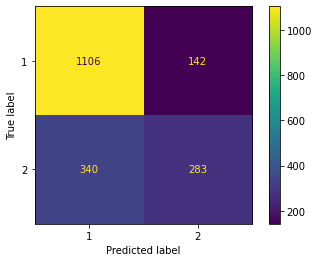

In [103]:
#instantiate vectorizer
ct_vect = CountVectorizer(ngram_range=(1,2)) 

#train and transform
X_train_vectorized = ct_vect.fit_transform(X_train)
X_test_vectorized = ct_vect.transform(X_test)

#instantiate model and fit
le_model = LogisticRegression(max_iter=700, solver='saga', C=0.5)
le_model.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(le_model, X_train_vectorized, y_train, X_test_vectorized, y_test)

## Additional Modeling 
* Random Forest
* SIV
* Keras

#### Unsupervised Learning


## Final Model 

Average Cross Validation Score:
0.7395769076552957

Test Accuracy:
0.7413148049171566

Precision Score:
0.7605729877216917

Recall Score:
0.8934294871794872
F1 Score:
0.8216654384672071


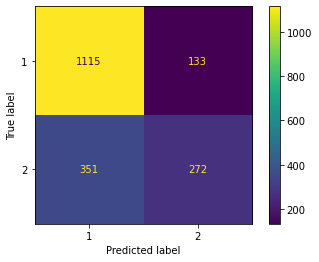

In [104]:
#instantiate vectorizer
ct_vect = CountVectorizer(stop_words='english', ngram_range=(1,2)) 

#train and transform
X_train_vectorized = ct_vect.fit_transform(X_train)
X_test_vectorized = ct_vect.transform(X_test)

#instantiate model and fit
le_model = LogisticRegression(max_iter=700, solver='saga', C=0.5)
le_model.fit(X_train_vectorized, y_train)

#evaluate model
model_evaluation(le_model, X_train_vectorized, y_train, X_test_vectorized, y_test)